In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import os, datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
LonFrom = -74.25559
LonTo = -73.70001
LatFrom = 40.49612
LatTo = 40.91553
regions = pd.read_csv("regions.csv",";")

In [3]:
def getRegion (longitude, latitude):
    binsX = np.linspace(LonFrom, LonTo, 51)
    binsY = np.linspace(LatFrom, LatTo, 51)
    reg = stats.binned_statistic_2d(longitude, latitude, None, 
                                              statistic = "count", bins = [binsX, binsY], expand_binnumbers=True)
    return (reg.binnumber[0] - 1) * 50 + reg.binnumber[1]


def grouped_data(tripdata):
    tripdata = tripdata[(tripdata['trip_distance'] != 0) & 
          (tripdata['passenger_count'] != 0) &
          (tripdata['tpep_pickup_datetime'] != tripdata['tpep_dropoff_datetime']) &
          (tripdata['pickup_longitude'] > LonFrom) &
          (tripdata['pickup_longitude'] < LonTo) &
          (tripdata['pickup_latitude'] > LatFrom) &
          (tripdata['pickup_latitude'] < LatTo)]

    tripdata['region'] = getRegion(tripdata.pickup_longitude, tripdata.pickup_latitude)

    tripdata.loc[:,'tpep_pickup_datetime'] = tripdata.tpep_pickup_datetime.dt.floor('h')

    tripdata_grouped = tripdata.groupby(['tpep_pickup_datetime', 'region']).size().reset_index(name='counts')
    tripdata_grouped = tripdata_grouped.set_index('tpep_pickup_datetime')
    return tripdata_grouped


In [4]:
esb_hourly = pd.DataFrame()
group_tripdata = pd.DataFrame()
for filename in os.listdir("rawdata"):
    print("started processing " + filename)
    if filename.endswith("csv"): 
        tripdata = pd.read_csv("rawdata/" + filename,",", 
                           parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
        group_tripdata = grouped_data(tripdata)
        esb_hourly = esb_hourly.append(group_tripdata[group_tripdata["region"] == 1231])
    
esb_hourly = esb_hourly.sort_values(by = "tpep_pickup_datetime")
esb_hourly.to_csv("esb_hourly.csv", sep=',')

started processing yellow_tripdata_2015-05.csv


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


started processing yellow_tripdata_2015-11.csv
started processing yellow_tripdata_2015-10.csv
started processing yellow_tripdata_2015-04.csv
started processing yellow_tripdata_2015-12.csv
started processing yellow_tripdata_2015-06.csv
started processing yellow_tripdata_2015-07.csv
started processing yellow_tripdata_2015-03.csv
started processing .DS_Store
started processing yellow_tripdata_2015-02.csv
started processing yellow_tripdata_2015-01.csv
started processing yellow_tripdata_2013-07.csv


/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


started processing yellow_tripdata_2013-12.csv
started processing yellow_tripdata_2013-06.csv
started processing yellow_tripdata_2013-10.csv
started processing yellow_tripdata_2013-04.csv
started processing yellow_tripdata_2013-05.csv
started processing yellow_tripdata_2013-11.csv
started processing yellow_tripdata_2014-08.csv
started processing yellow_tripdata_2013-01.csv
started processing yellow_tripdata_2014-09.csv
started processing yellow_tripdata_2013-02.csv
started processing yellow_tripdata_2013-03.csv
started processing yellow_tripdata_2016-02.csv
started processing yellow_tripdata_2014-07.csv
started processing yellow_tripdata_2014-06.csv
started processing yellow_tripdata_2014-12.csv
started processing yellow_tripdata_2016-03.csv
started processing yellow_tripdata_2016-01.csv
started processing yellow_tripdata_2014-04.csv
started processing yellow_tripdata_2014-10.csv
started processing yellow_tripdata_2014-11.csv
started processing yellow_tripdata_2014-05.csv
started proce

<h1>You can start from below. Above I just prepared a data. 

In [2]:
esb_hourly = pd.read_csv("esb_hourly.csv", sep = ",", parse_dates=['tpep_pickup_datetime'],
                   index_col = "tpep_pickup_datetime")
#esb_hourly = esb_hourly.drop(columns = "region")

Adding missed rows of time series to datframe and filling it with zeros

In [3]:
time_range = pd.date_range(start="2013-01-01 00:00:00", end = '2016-05-31 23:00:00', freq = 'H' )
tripdata_full = pd.DataFrame()
tripdata_full["tpep_pickup_datetime"] = time_range
tripdata_full["region"] = 1231
tripdata_full["counts"] = 0
tripdata_full = tripdata_full.set_index('tpep_pickup_datetime')
tripdata_full_data = pd.merge_asof(tripdata_full, esb_hourly, on='region', 
                                                               by = ['tpep_pickup_datetime','region'])

tripdata_full_data = tripdata_full_data.fillna(0)
tripdata_full_data = tripdata_full_data.set_index('tpep_pickup_datetime')
esb_hourly = tripdata_full_data.drop(columns = ["counts_x","region"])
esb_hourly.columns = ['counts']
esb_hourly.head()

,counts
tpep_pickup_datetime,
2013-01-01 00:00:00,1041.0
2013-01-01 01:00:00,821.0
2013-01-01 02:00:00,700.0
2013-01-01 03:00:00,755.0
2013-01-01 04:00:00,600.0


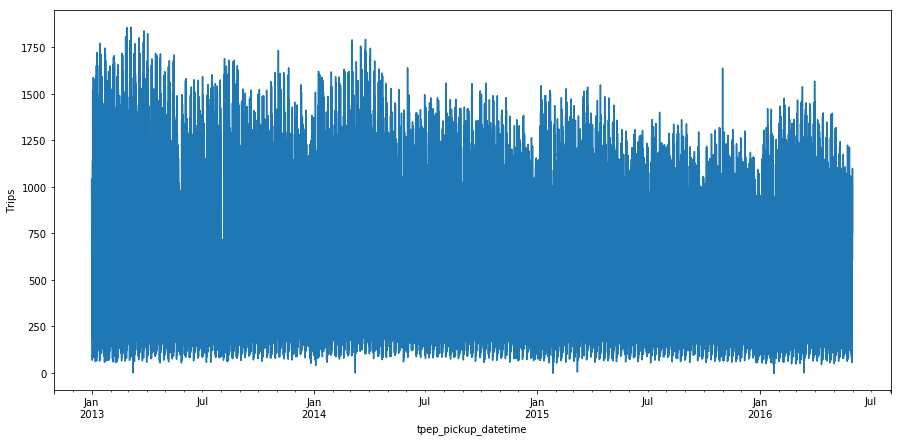

In [27]:
plt.figure(figsize(15,7))
esb_hourly.counts.plot()
plt.ylabel('Trips')
pylab.show()

In [4]:
dt_from = datetime.datetime.strptime("2016-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
dt_to = datetime.datetime.strptime("2016-05-31 23:00:00", "%Y-%m-%d %H:%M:%S")
esb_hourly_2016 = esb_hourly[(esb_hourly.index <= dt_to) & 
          (esb_hourly.index >= dt_from)]

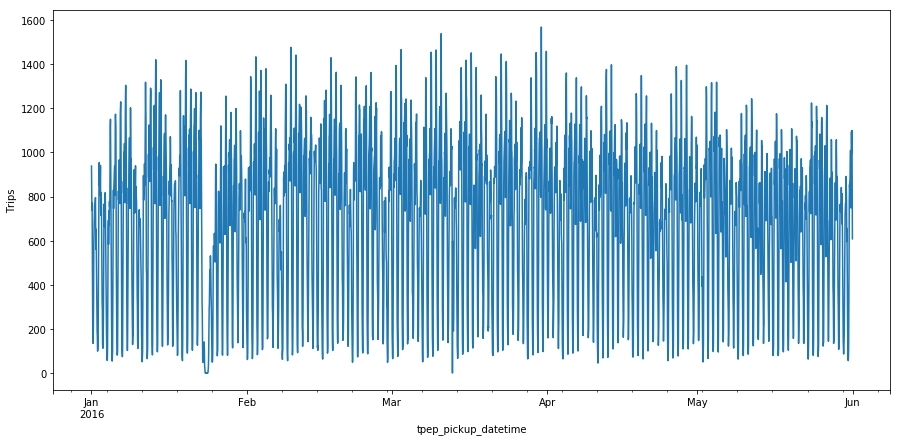

In [29]:
plt.figure(figsize(15,7))
esb_hourly_2016.counts.plot()
plt.ylabel('Trips')
pylab.show()

<Figure size 1080x720 with 0 Axes>

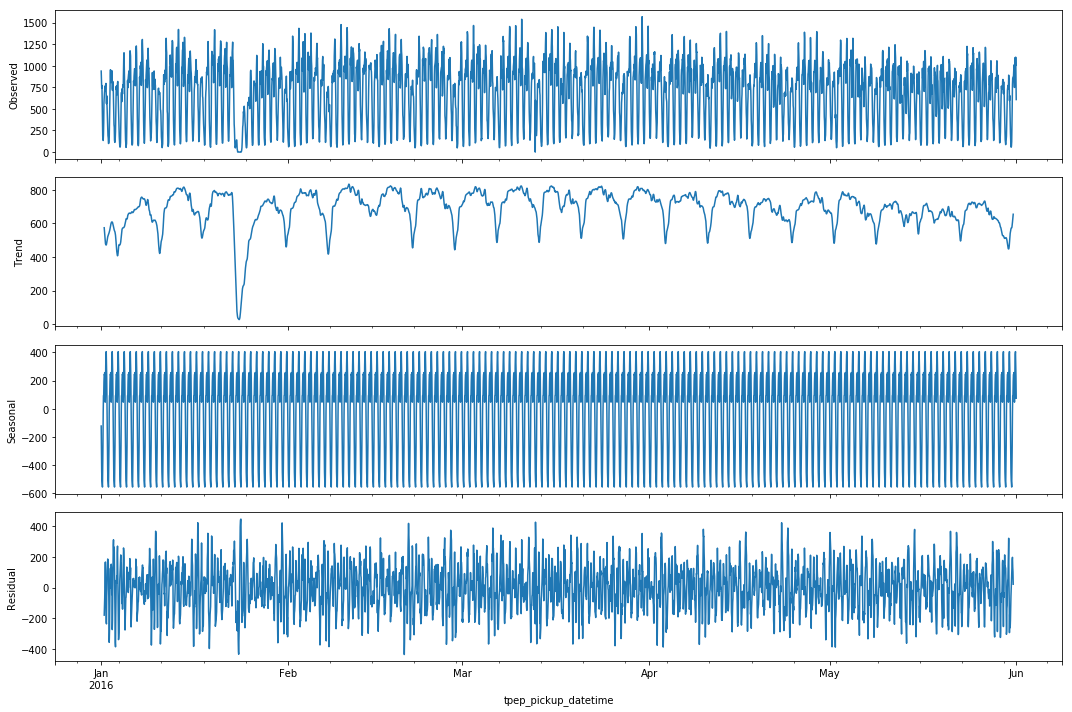

In [5]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(esb_hourly_2016['counts'], freq = 24).plot();

Let's discover anomaly in the end of Jan in more details

<Figure size 1080x720 with 0 Axes>

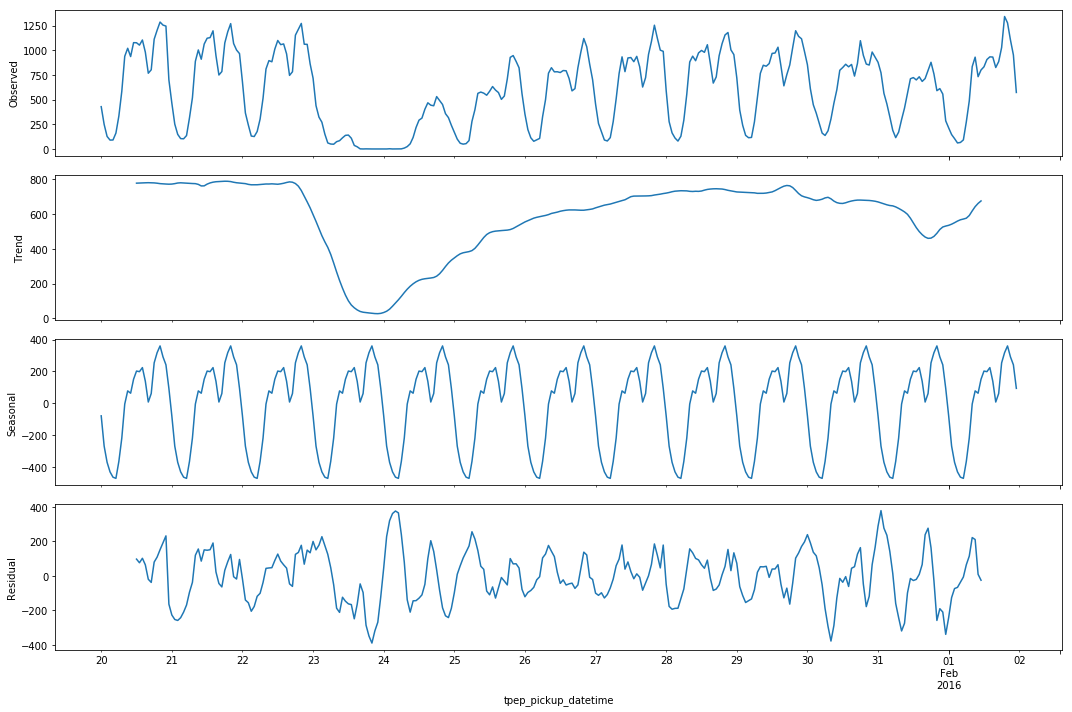

In [31]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(esb_hourly_2016.counts.loc['2016-01-20':'2016-02-01'], freq = 24).plot();

The reason of the anomaly is the snowstorm in NY at that time:

https://en.wikipedia.org/wiki/January_2016_United_States_blizzard

To find the values of the ARIMA hyperparameters, will try to make a series of residues stationary. Let's find out the number of differentiations.

Let's prepare features to describe weekly seasonality
\begin{equation}
s\displaystyle _{i}=\sin([1,...,T]*2\pi i/168),  c\displaystyle _{i}=\cos([1,...,T]*2\pi i/168), i = 1,...,K
\end{equation}

We need to find the K with the least residuals.

\begin{equation}
s\displaystyle _{i}=\sin([1,...,T]*2\pi i/168),  c\displaystyle _{i}=\cos([1,...,T]*2\pi i/168), i = 1,...,K
\end{equation}


In [6]:
mse = []
K = 150
for number in range (1, K + 1):
    temp_data = esb_hourly_2016.copy()
    for i in range(1, number + 1):        
        temp_data['s_' + str(i)] = np.sin(np.arange(1, temp_data.shape[0]+1)*2*np.pi*i/168)
        temp_data['c_' + str(i)] = np.cos(np.arange(1, temp_data.shape[0]+1)*2*np.pi*i/168)
    X = temp_data.loc[:, 's_1':]
    y = temp_data.counts
    m = LinearRegression()
    #We need a try since on some values of K the model will not converge
    try:
        res = m.fit(X, y)
    except LinAlgError:
        mse.append(np.inf)
        print('wrong parameter of K (SVD did not converge in Linear Least Squares):', number)
        continue
    mse.append(mean_squared_error(y, res.predict(X)))
    K_least_mse = np.argmin(mse)
print 'The least MSE is when K =', K_least_mse

The least MSE is when K = 149


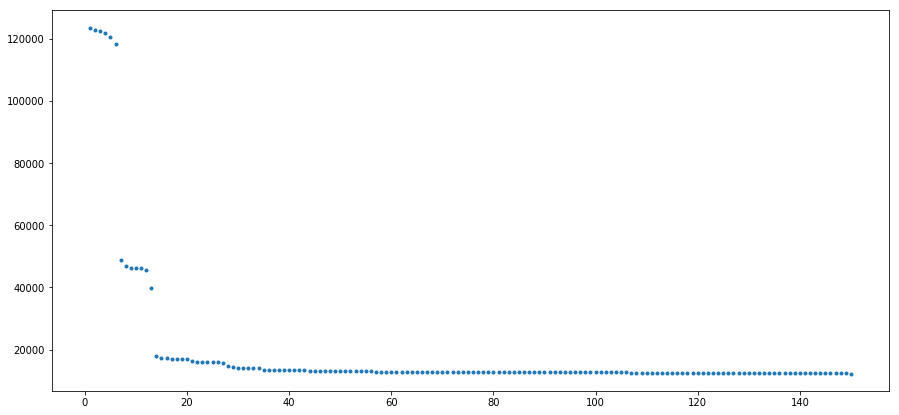

In [7]:
plt.figure(figsize(15, 7))
plt.plot(np.arange(1, K + 1), mse, linestyle='None', marker='.')

In [8]:
K_least_mse = 50

In [9]:
for i in range(1, K_least_mse+1):        
        esb_hourly_2016['s_'+str(i)] = np.sin(np.arange(1, esb_hourly_2016.shape[0]+1)*2*np.pi*i/168)
        esb_hourly_2016['c_'+str(i)] = np.cos(np.arange(1, esb_hourly_2016.shape[0]+1)*2*np.pi*i/168)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
X = esb_hourly_2016.loc[:, 's_1':]
y = esb_hourly_2016.counts

model = LinearRegression()
model_fit = model.fit(X, y)
y_predicted = model_fit.predict(X)

esb_hourly_2016['prediction'] = y_predicted
esb_hourly_2016['residuals'] = y - y_predicted

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
model_fit.score(X, y)

0.897835428941799

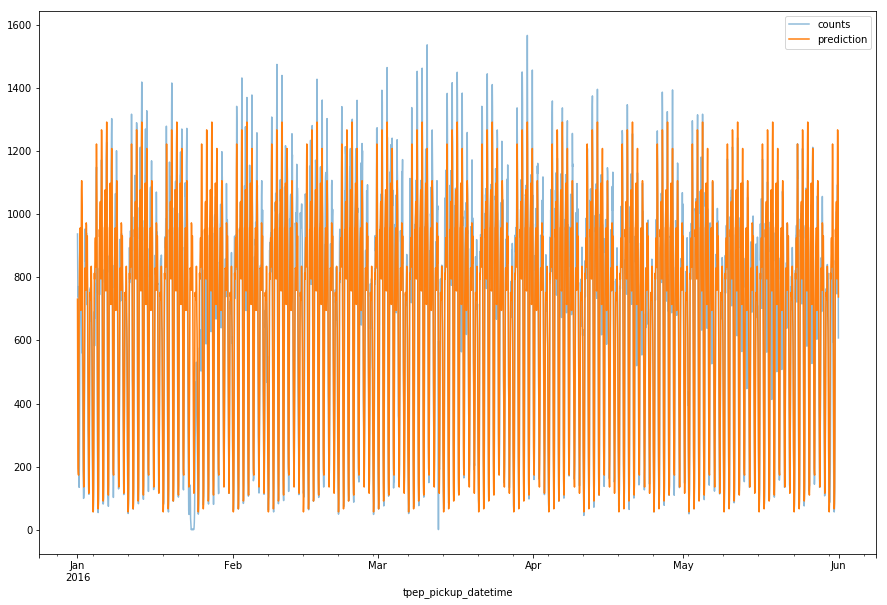

In [12]:
plt.figure(figsize(15, 10))
esb_hourly_2016.counts.plot(alpha = 0.5, legend = True)
esb_hourly_2016.prediction.plot(legend = True)

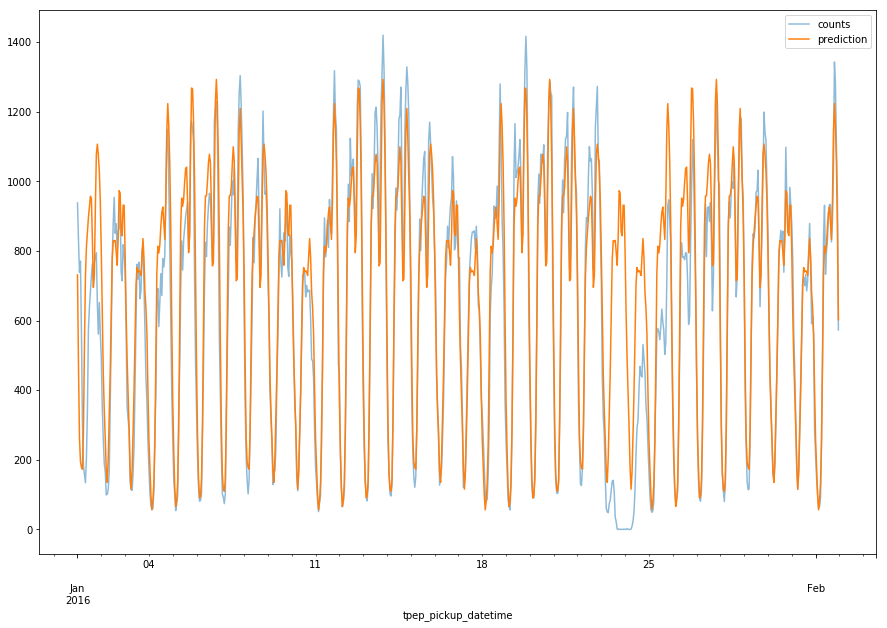

In [13]:
plt.figure(figsize(15, 10))
esb_hourly_2016.loc['2016-01-01':'2016-02-01','counts'].plot(alpha = 0.5, legend = True)
esb_hourly_2016.loc['2016-01-01':'2016-02-01','prediction'].plot(legend = True)

STL for residuals

<Figure size 1080x720 with 0 Axes>

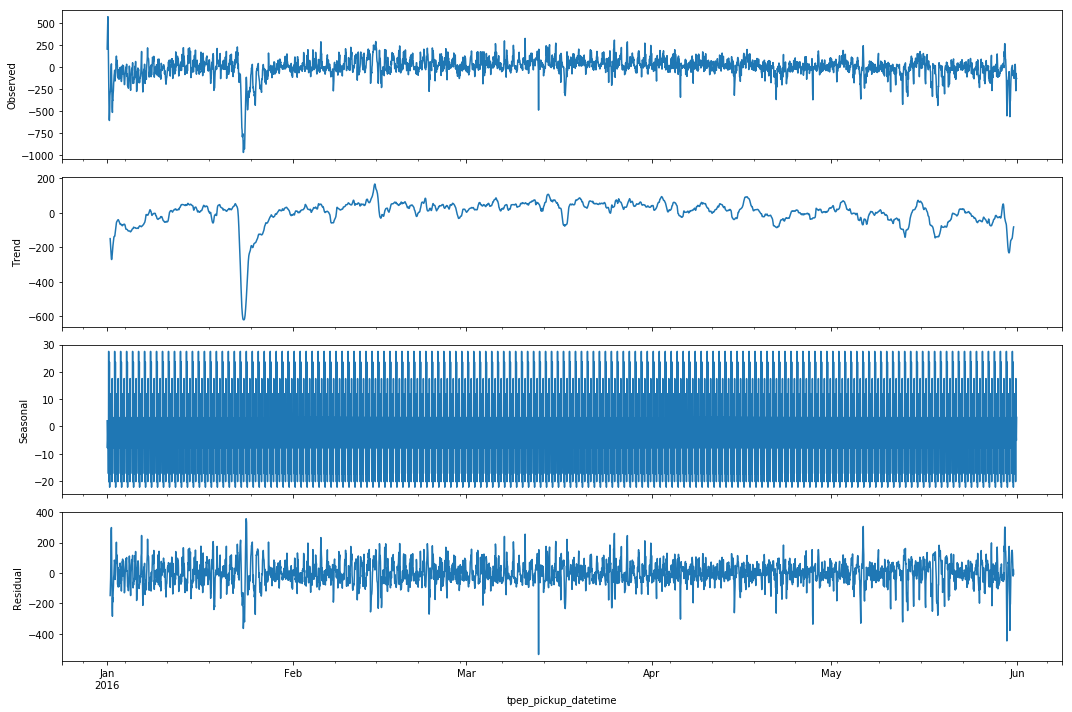

In [14]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(esb_hourly_2016['residuals']).plot();

In [15]:
print "Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(esb_hourly_2016.counts)[1]

Dickey - Fuller test: p =  1.4746102923763146e-10


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<Figure size 1080x720 with 0 Axes>

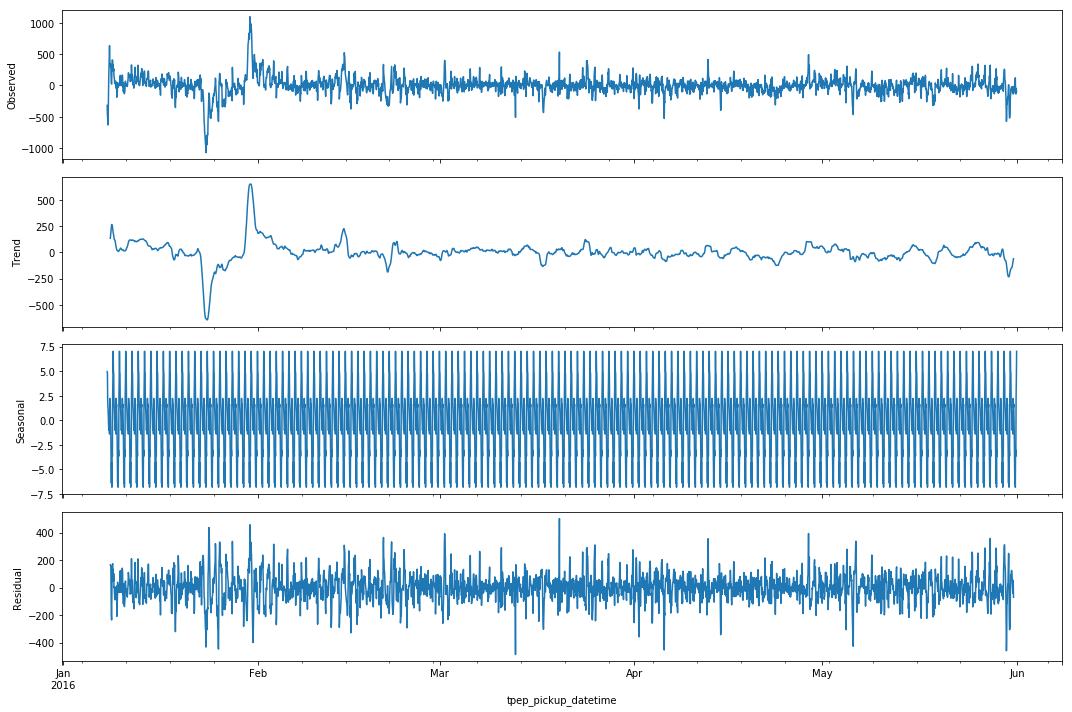

In [16]:
esb_hourly_2016['residuals_dif'] = esb_hourly_2016.residuals-esb_hourly_2016.residuals.shift(168)
#plot_sd(residuals.remains_dif[168:])
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(esb_hourly_2016.residuals_dif[168:], freq = 24).plot();

In [17]:
print("Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(esb_hourly_2016.residuals_dif[168:])[1])

('Dickey - Fuller test: p = ', 1.2792494607403775e-11)


The nonstationarity hypothesis can be rejected, so assuming that the time series is stationary. 

Trying to adjust hyperparams for ARIMA

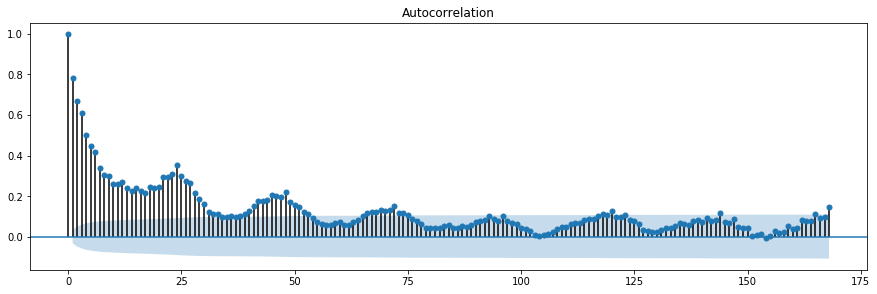

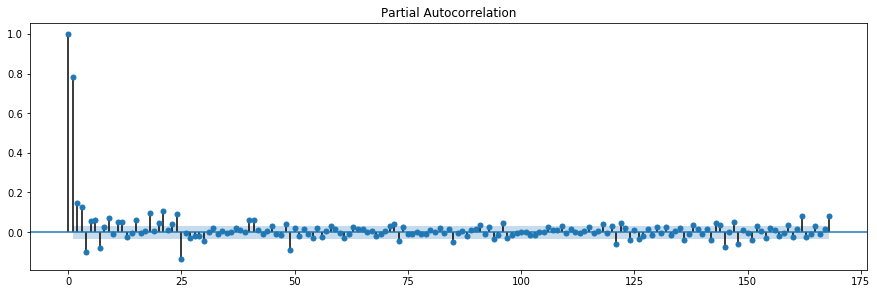

In [18]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(esb_hourly_2016.residuals[168:].values.squeeze(), lags = 168, ax = ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(esb_hourly_2016.residuals[168:].values.squeeze(), lags = 168, ax = ax)
plt.show()

Initial approximation: Q = 1 q = 3 P = 1 p = 4

In [20]:
ps = range(0, 5)
d = 1
qs = range(0, 4)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

80

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
exog = esb_hourly_2016.loc[:, 's_1':'s_50']

for param in parameters_list:
    #we need try except since the model will not not fit on some parameter sets
    try:
        model=sm.tsa.statespace.SARIMAX(esb_hourly_2016.counts, exog = exog, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 168)).fit(disp=-1)
    #вdisplay parameters on which the model didn't fit and proceed to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print 'parameters:{} have aic value {}'.format(param, aic)
    #saving the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

parameters:(0, 0, 0, 0) have aic value 65801.7512461


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
print(best_model.summary())

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

In [ ]:
mean_resid = np.abs(best_model.resid.values.mean())
print mean_resid

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze() + mean_resid , lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid + mean_resid , 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid + mean_resid)[1])

In [ ]:
esb_hourly_2016['model'] = best_model.fittedvalues + mean_resid

In [ ]:
esb_hourly_2016['model'].plot()
esb_hourly_2016['trips'].plot()

In [ ]:
esb_hourly_2016.loc['2016-01':'2016-02','trips'].plot(legend = True)
esb_hourly_2016.loc['2016-01':'2016-02','prediction'].plot(legend = True, alpha = 0.5)
esb_hourly_2016.loc['2016-01':'2016-02','model'].plot(legend = True, alpha = 0.5, colormap = 'magma')